![head.png](figures/head.jpg)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

In [98]:
# Packages used in this notebook
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy import optimize
import matplotlib.pyplot as plt

# Financial time series

Temporal financial data with observations that occur at some time $t$. Most financial data can be expressed as a time series.

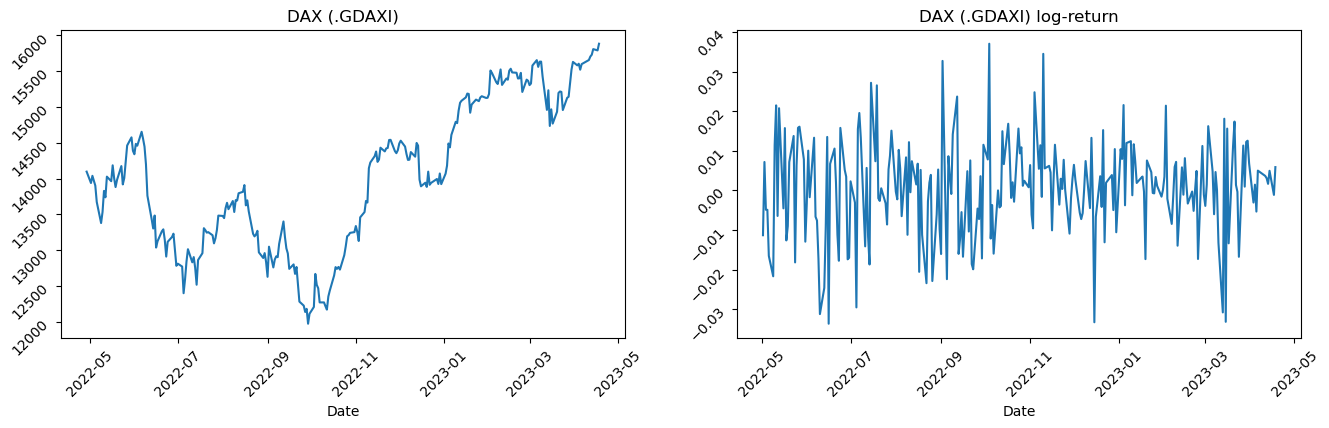

In [99]:
# Read data from CSV file
prices = pd.read_csv('homework/02_python_data.csv', index_col=0, parse_dates=True)
returns = prices.pct_change()
logreturns = np.log(prices) - np.log(prices.shift(1))

fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(prices[".GDAXI"])
axs[0].set_xlabel('Date')
axs[0].title.set_text("DAX (.GDAXI)")
axs[0].tick_params(labelrotation=45)

axs[1].plot(logreturns[".GDAXI"])
axs[1].set_xlabel('Date')
axs[1].title.set_text("DAX (.GDAXI) log-return")
axs[1].tick_params(labelrotation=45)

## Correlation

Correlation is a statistical measure that quantifies the degree of association between two variables. In the context of finance, correlation is used to determine how closely the returns of two assets, indices, or other financial instruments move together over time.  Correlation may indicate any type of association, in statistics it usually refers to the degree to which a pair of variables are linearly related. Correlation is therefore often measured as the Pearson correlation coefficient, a measure for linear association between two random variables $X$ and $Y$

$$\rho_{X,Y} = \text{corr}(X,Y) = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y} = \frac{\mathrm{E}[(X - \mu_x)(Y - \mu_Y)]}{\sigma_X \sigma_Y}, \text{  if  } \sigma_X \sigma_Y > 0$$

A high positive correlation indicates that the assets tend to move in the same direction, while a high negative correlation implies that they move in opposite directions. A correlation close to zero suggests no significant relationship between the two assets. 

Linear association, as measured by Pearson's correlation coefficient does not adequately capture non-linear associations. As an example, consider the random variable $X$ as well as $Y = X^2$.

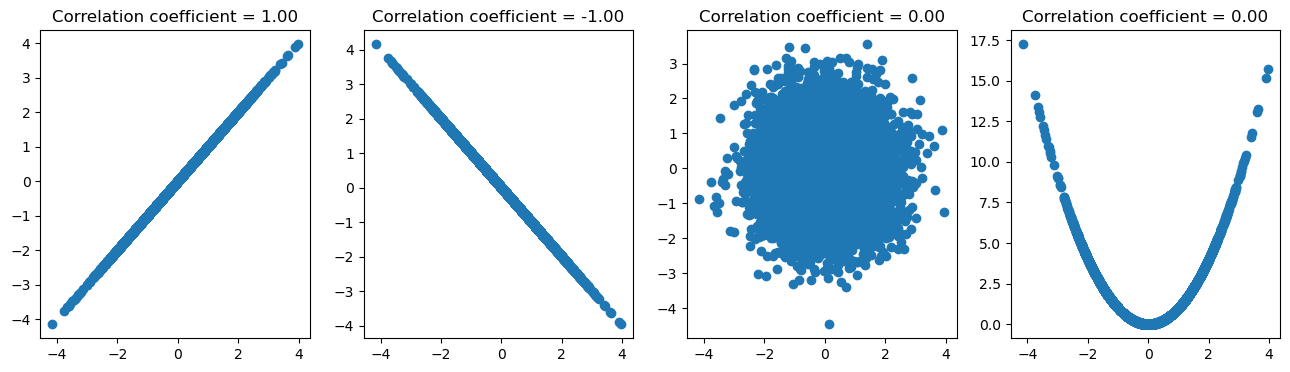

In [100]:
np.random.seed(88888)
X = np.random.normal(size=10000)
Y = np.random.normal(size=10000)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# Positive
axs[0].scatter(X,X)
axs[0].title.set_text(f"Correlation coefficient = {np.corrcoef(X,X)[0,1]:.2f}")
# Negative
axs[1].scatter(X,-X)
axs[1].title.set_text(f"Correlation coefficient = {np.corrcoef(X,-X)[0,1]:.2f}")
# Independent
axs[2].scatter(X,Y)
axs[2].title.set_text(f"Correlation coefficient = {np.corrcoef(X,Y)[0,1]:.2f}")
# Non-linear
axs[3].scatter(X,X**2)
axs[3].title.set_text(f"Correlation coefficient = {np.corrcoef(X,X**2)[0,1]:.2f}")
plt.show()

## Linear regression

Consider a simple univariate [linear regression model](https://en.wikipedia.org/wiki/Linear_regression) of the form

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

We often call $\beta_0$ the intercept and $\beta_1$ the slope or steepness.

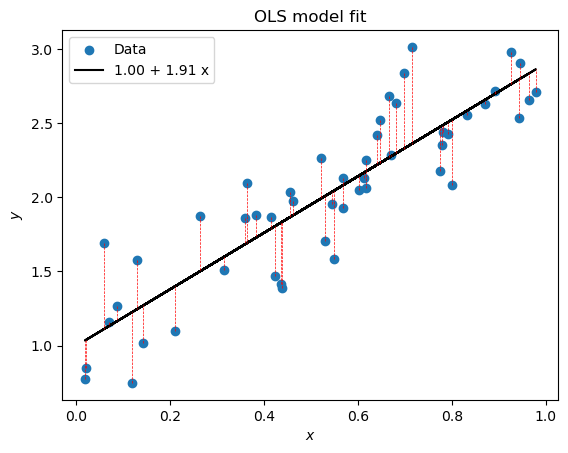

In [101]:
# Generate sample data
np.random.seed(0)
x = np.random.rand(50)
y = 2 * x + 1 + 0.3 * np.random.normal(0, 1, len(x))

# Fit a linear model
def fun(beta):
    y_hat = beta[0] + beta[1] * x
    squares = (y - y_hat)**2
    return sum(squares)
# Ordinary least squares (OLS)
result = optimize.minimize(fun, x0=[0,0], method='BFGS')
intercept, slope = result.x

#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_hat = slope * x + intercept
# Calculate residuals
residuals = y - y_hat

# Plot the scatter plot with linear model fit
plt.scatter(x, y, label='Data')
plt.plot(x, y_hat, color='black', label=f'{intercept:.2f} + {slope:.2f} x')
# Indicate the residuals
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], y_hat[i]], color='red', linestyle='--', linewidth=0.5)
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.legend()
plt.title('OLS model fit')
plt.show()

### Coefficient of determination (R-squared)

R-squared $R^2$ is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. It provides a measure of how well the observed data can be explained by the model.

$$
R^2 = \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y}_i)^2} = \frac{\sum_i \epsilon_i^2}{\sum_i (y_i - \bar{y}_i)^2} = \frac{ \text{Residual sum of squares} }{ \text{Total sum of squares} },
$$

where $y_i$ is the observed and $\bar{y}_i$ is the prediction value. You can think of it this way: we compute the ratio between the errors from prediction $\hat{y}_i$ versus the errors from naively predicting $y_i$ with its average $\bar{y}_i$. The fraction of variance that can be explained by the model is therefore $R^2$, and the fraction that cannot be explained is $1 - R^2$.

In a linear regression with intercept, $R^2$ is the square of the Person correlation coefficient between observed and predicted values of the dependent variable, i.e.

$$
R^2 = \rho_{X,Y}^2
$$


In [102]:
# R-squared
residual_sum_squares = sum((y - y_hat)**2)
total_sum_squares = sum((y - y.mean())**2)
print(f"R-squared   = {1 - residual_sum_squares / total_sum_squares:.4f}")
# Correlation squared
print(f"Corr(X,Y)^2 = {np.corrcoef(x,y)[0,1]**2:.4f}")

R-squared   = 0.7780
Corr(X,Y)^2 = 0.7780


### Multivariate linear regression (`scipy.stats`)

Multivariate linear regression is a statistical technique that allows us to predict the value of one dependent variable (also known as the outcome variable) based on the values of two or more independent variables (also known as predictor variables). It is an extension of simple linear regression that involves more than one explanatory variable, hence,

$$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_p x_{ip} + \epsilon_i$$

which can be expressed in matrix notation as

$$
\mathbf{y} = \mathbf{X} \mathbf{\beta} + \mathbf{\epsilon}
$$



In [103]:
# Generate example data
np.random.seed(0)
x1 = np.random.rand(50)
x2 = np.random.rand(50)
x3 = np.random.rand(50)
# Create a dependent variable + error
y = 2*x1 + 5*x2 + 1 + 0.3 * np.random.normal(0, 1, len(x))
# Note that y is not a function of x3

# Combine the vectors of explanatory variables
X = np.column_stack([x1, x2, x3])
# Add the intercept, i.e. prepend a vector of ones
X = sm.add_constant(X)
# Fit the model
fitted_model = sm.OLS(y, X).fit()
# Show results
print(fitted_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     440.3
Date:                Tue, 09 May 2023   Prob (F-statistic):           7.14e-34
Time:                        23:27:56   Log-Likelihood:                -8.2512
No. Observations:                  50   AIC:                             24.50
Df Residuals:                      46   BIC:                             32.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9363      0.157      5.958      0.0